# Projet Pseudo-Extended Markov Chain Monte Carlo

# Introduction

On rappelle ici quelques algorithmes MCMC.

# ***Algorithme Metropolis-Hastings***

- On tire un candidat aléatoire suivant une distribution prédéterminée
 
-	L’algorithme choisit un candidat basé sur l’échantillon courant

-	On accepte ou refuse le candidat avec un certain taux d’acceptation définit par le rapport entre le candidat et notre échantillon actuel de la fonction qu’on souhaite estimer pondéré par la probabilité de transition réciproque entre les deux états. (En utilisant des distributions symétriques comme les gaussiennes le rapport précédent se réduit au rapport de l’évaluation de la fonction f entre notre candidat et notre actuel échantillon).

$$\alpha = \frac{f(x')g(x_t,x')}{f(x_t)g(x',x_t)}$$

-	On tire un nombre $U$ entre 0 et 1 de manière uniforme. On compare notre taux d’acceptance à $U$. Si $U$ est plus grand que notre taux d’acceptance, on rejette le candidat, sinon on accepte.

L’ajout de ce tirage aléatoire pour accepter le nouveau candidat est essentiel pour la visite d’états moins probables et éviter de se retrouver dans des maximum locaux. Cela permet donc d’améliorer les capacités d’exploration de l’espace d’états de notre chaîne tout en se dirigeant globalement vers les zones à forte densité de probabilité. En effet on utilise généralement cet algorithme pour échantillonner de distributions multidimensionnelles et on aura une phase de burning où les échantillons ne suivent pas nos échantillons dans le commencement.

Les méthodes de rejet souffrent du fléau de la dimension qui se traduit ici par le fait que la probabilité de rejet augmente exponentiellement avec le nombre de dimensions. En recourant aux méthodes MCMC on allège ce problème et donc on aura tendance à privilégier MCMC pour l’échantillonnage de distributions à hautes dimensions.

L’algorithme Metropolis–Hastings décrit plus haut suppose de choisir à chaque itération un nouvel échantillon dans l'espace multi-dimensionnel.

Trouver le pas de déplacement avec MH est complexe lorsque la dimension est élevée, car chaque dimension peut avoir un comportement qui lui est propre, et il faut avoir un pas adapté pour se déplacer de la meilleure des manières pour l’exploitation de notre espace d’états.

# ***Algorithme Monte Carlo Hamiltonien***

En statistiques, l'algorithme de Monte Carlo Hamiltonian est une méthode d’échantillonnage de Monte Carlo utilisant le formalisme des chaînes de Markov. L’objectif est d'obtenir une séquence d’échantillons aléatoires qui convergent selon une distribution de probabilité cible, typiquement difficile à échantillonner directement. Cette séquence peut notamment être utilisée pour estimer des intégrales par rapport à une distribution cible (avantageux pour le calcul de moyenne/espérance empiriquement ou certains paramètres caractéristiques de nos distributions).

- **Distribution cible :** $\pi$ sur $\mathbb{R}^d$, $\pi(q) \propto \mathrm{e}^{-U(q)}$.
- **Distribution cible étendue :** $\bar\pi$ sur $\mathbb{R}^d \times \mathbb{R}^d$, $\bar\pi(q,p) \propto \mathrm{e}^{-U(q)-p^Tp/2}$

En posant $U$ l'énergie potentielle, $K$ l'énergie cinétique, le hamiltonien s'écrit :
$$H(p,q) = U(q) + K(p)$$

Le Monte Carlo hamiltonien correspond à une instance de l’algorithme Metropolis-Hastings où les déplacements proposés dans l'espace d'états sont issus d'un processus gouverné par une dynamique Hamiltonienne et simulée à l'aide d'un integrateur numérique reversible et préservant le volume (généralement la méthode Leapfrog comme présentée en cours).

Méthode _leapfrog_ : pour $0 \leqslant \ell \leqslant L$ :
$$p_{k+1}^{\ell+1/2} = p_{k+1}^\ell - \frac h2 \nabla U(q_{k+1}^\ell)$$
$$q_{k+1}^{\ell+1} = q_{k+1}^\ell + h p_{k+1}^{\ell+1/2}$$
$$p_{k+1}^{\ell+1} = p_{k+1}^{\ell+1/2} - \frac h2 \nabla U(q_{k+1}^{\ell+1})$$

On produit des valeurs de manière itérative et la probabilité de l'échantillon à l'étape suivante ne dépend que de l'échantillon à l'étape considérée. (Caractère Markovien de notre chaîne)

Le caractère réversible implique l’égalité suivante en notant g notre probabilité de transitions entre deux états : (qui est respectée pour MH et HMC)

$$g(x|y)\pi(y) = g(y|x)\pi(x)$$

Par rapport à la distribution de proposition de marche aléatoire gaussienne utilisée dans l'algorithme de Metropolis-Hastings, la méthode hamiltonienne de Monte Carlo réduit la corrélation entre les états d'échantillonnage consécutifs en proposant une transition vers un état distant. La corrélation réduite signifie que moins d'échantillons de la chaîne de Markov sont nécessaires pour approximer l'intégrale de la distribution de probabilité cible pour une erreur de Monte Carlo donnée.

## Problème initial


Les méthodes de Monte Carlo sont utilisées pour échantilloner à partir d'une densité de probabilité que l'on connaît à une constante multiplicative près. 

Asymptotiquement, ces méthodes permettent d'échantilloner selon la distribution correcte, mais elles peuvent nécessiter beaucoup d'itérations avant de parvenir à cet état stationnaire. Cela est notamment le cas si la distribution que l'on cherche à approcher est complexe, comme les distributions multi-modales que l'on retrouve dans les _mixture models_, les réseaux de neurones et les modèles d"équations différentielles par exemple.



## Solution proposée dans l'article

La méthode pseudo-extended Markov chain Monte Carlo présentée dans l'article consiste à augmenter artificellement l'espace des états de la distribution pour permettre à l'échantilloneur MCMC de bouger plus facilement entre les espaces où la valeur de la densité est élevée. Un exemple d'une distribution initiale qui peut poser ce genre de problème est donné ci-dessous, le code provenant du cours. On implémente une distribution qui est une mixture de deux gaussiennes et on applique HMC pour voir si l'algorithme parvient à identifier les deux modes.



In [ ]:
"""""""""""""""""
Required packages
"""""""""""""""""
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm

In [ ]:
# Define functions required to generate a mixture of multi-Gaussian distributions
def multi_gauss(mu, sigma):
    """
    Inputs
    ----------
    mu: mean of the Gaussian distribution
    sigma: covariance matrix of the Gaussian distribution
    
    Outputs
    -------
    logp: opposite of the loglikelihood
    """

    def logp(x):
        #k   = mu.shape[0]
        cst       = np.log(2 * np.pi)
        #det       = np.log(np.abs(sigma))
        quad_term = 1/sigma * (x- mu)**2
        return (cst +  sigma + quad_term) * 0.5
    
    return logp

def mixture(log_prob, weights):
    """
    Inputs
    ----------
    log_prob: opposite of the likelihood of each term
    weights: weights of the components of the mixture
    
    Outputs
    -------
    logp: opposite of the loglikelihood of the mixture
    """
    
    def logp(x):
        likelihood = 0
        for j in range(np.size(weights)):
            log_marginal = -log_prob[j](x)
            likelihood   = likelihood + weights[j]*np.exp(log_marginal)
        
        return -np.log(likelihood)

    return logp

In [ ]:
# Generate an example of a multi-modal distribution
mu1 = 2.5
cov1 = 1
mu2 = -1.5*mu1
cov2 = 0.5

log_p = mixture([multi_gauss(mu1, cov1), multi_gauss(mu2, cov2)], [0.25, 0.35])

In [ ]:
# Required to display the results
grid_lim = 6
nb_points = 100
Xplot = np.linspace(-grid_lim, grid_lim, nb_points)

(100,)


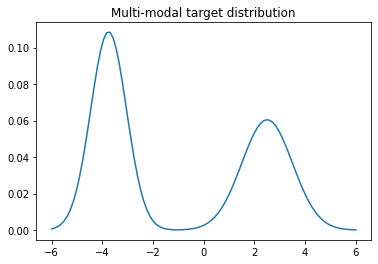

In [ ]:
# Display the multi-modal distribution generated above
plt.title('Multi-modal target distribution')
Zplot = np.copy(Xplot)
for i in range(nb_points):
      Zplot[i] = np.exp(-log_p((Xplot[i])))
print(Zplot.shape)
plt.plot(Xplot,Zplot)

In [ ]:
def q_instr(mu,sigma,x):
  # normal law
  return 1/(np.sqrt(2*np.pi) * sigma) * np.exp((x-mu)**2/sigma**2)

nb_points = 100

xplot = np.linspace(-grid_lim, grid_lim, nb_points)
yplot = np.linspace(-grid_lim, grid_lim, nb_points)
Xplot2, Yplot2 = np.meshgrid(xplot, yplot)

Zplot_extended = np.zeros((len(Xplot2),len(Xplot2)))

for i in range(len(Xplot2)):
  for j in range(len(Xplot2)):
    Zplot_extended[i,j] = Zplot[i]*q_instr(0,2,Zplot[j]) + Zplot[j]*q_instr(0,2,Zplot[i])

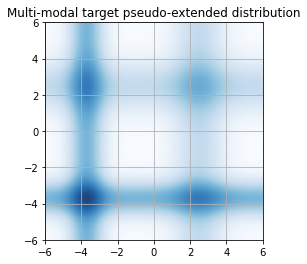

In [ ]:
plt.title('Multi-modal target pseudo-extended distribution')
grid_plot = (-grid_lim, grid_lim, -grid_lim, grid_lim)
plt.imshow(Zplot_extended, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
plt.grid(True)

In [ ]:
log_density = log_p
gradV = grad(log_density)

In [ ]:
def leapfrog_integrator(q, p, gradientV, T, step):
    """
    Inputs
    ----------
    q: initial position
    p: initial momentum
    gradientV: gradient of the velocity
    T: time horizon
    step: step size to discretize the ODE
    
    Outputs
    -------
    q, p: last position and last momentum
    positions: sequence of positions produced by the leapfrog integrator
    momentums: sequence of momentums produced by the leapfrog integrator
    """
    
    q, p      = np.copy(q), np.copy(p)
    pos, moms = [np.copy(q)], [np.copy(p)]

    vq = gradientV(q)
    nb_steps = int(T / step)
    
    for it in range(nb_steps):
        p = p - 0.5*step * vq 
        q = q + step * p  
        pos.append(np.copy(q))
        vq = gradientV(q)
        p = p - 0.5*step * vq
        moms.append(np.copy(p))

    return q, -p, np.array(pos), np.array(moms)

Position de départ -0.9503058528907858


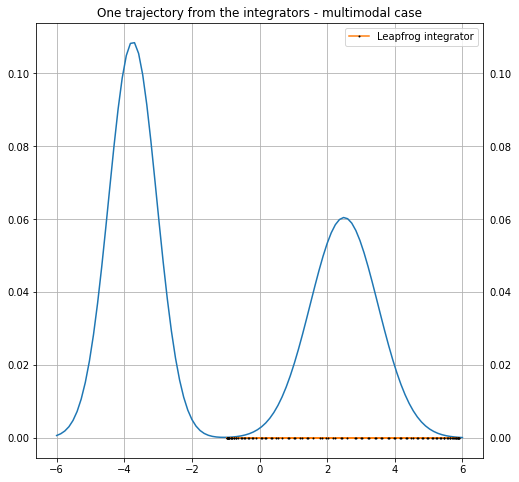

In [ ]:
q, p = np.random.randn(2)
print("Position de départ", q)
_, _, positions_leap, momentums_leap = leapfrog_integrator(q, p, gradV, 10 * np.pi, 0.3)
fig = plt.figure(figsize=(8,8))
plt.title('One trajectory from the integrators - multimodal case')

#Zplot = np.copy(Xplot)
#for i in range(nb_points):
#    for j in range(nb_points):
#        Zplot[i][j] = np.exp(-log_density(np.array((Xplot[i][j], Yplot[i][j]))))

plt.plot(Xplot, Zplot)
plt.plot(np.array(positions_leap), np.zeros(np.array(positions_leap).shape), marker='o', markersize = 1, markeredgecolor='black', label = 'Leapfrog integrator')

plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

On voit qu'avec l'application d'un Hamiltonian Monte Carlo, on parvient à identifier la plupart du temps seulement un des deux modes de la distribution. La méthode proposée ci-dessous permet de répondre à ce problème. 

# Pseudo-extended method

## Présentation de la méthode

Soit $\pi$ une densité de probabilité sur $\mathcal{X} = \mathbb{R}^d$ définie pour tout $x$ par 
$$
\pi(\textbf{x}) := \frac{\gamma(\textbf{x})}{Z} = \frac{\exp(-\phi(\textbf{x}))}{Z}
$$
avec $\phi$ une fonction continue et différentiable et $Z$ la constante de normalisation.

On étend l'espace des états de la distribution initiale $\pi$ en introduisant $N$ "pseudo-échantillons" $x_{1:N} = \{\textbf{x}_{i}\}_{i=1}^N$, ou la distribution étendue est $\pi^N(\textbf{x}_{1:N})$ définie sur $\mathcal{X}^N$.

Ces pseudo-échantillons jouent le rôle de variables auxiliaires, où pour chaque $\textbf{x}_{i}$ on introduit la distribution instrumentale $q(\textbf{x}_{i}) \propto \exp(-\delta(\textbf{x}_{i}))$ où $\delta$ est une fonction.

La distribution étendue est alors définie comme suit :
$$
\pi^N(\textbf{x}_{1:N}) := \frac{1}{N} \sum_{i=1}^N \pi(\textbf{x}_{i}) \prod_{j \ne i} q(\textbf{x}_{j}) = \frac{1}{Z} \left\{ \frac{1}{N} \sum_{i=1}^N \frac{\gamma(\textbf{x}_{i})}{q(\textbf{x}_{i})}\right\} \prod_{i} q(\textbf{x}_{i})
$$

Par intégrations successives, on obtient que la distribution marginale du $i$-ième pseudo-échantillon est une mixture entre la distribution initiale et la distribution instrumentale
$$
\pi^N(\textbf{x}_{i}) := \frac{1}{N} \pi(\textbf{x}_{i}) + \frac{N-1}{N} q(\textbf{x}_{i})
$$


Il reste maintenant à convertir les échantillons de la distribution étendue en échantillons de $\pi(\textbf{x})$ pour pouvoir répondre au problème de départ.

Pour cela on utilise un processus de pondération avec des poids, qui permet d'obtenir à partir de la simulation de la distribution étendue une espérance non biaisée selon $\pi$ de fonctions $f$ arbitraires intégrables. La valeur de ces poids est donnée dans le théorème suivant.

**Théorème**

Soient $\textbf{x}_{1:N}$ distribuées selon $\pi^N(\textbf{x}_{1:N})$. Pondérer chaque échantillon par les poids normalisés proportionnels à $\frac{\gamma(\textbf{x}_{i})}{q((\textbf{x}_{i})}$ pour $i=1, \dots, N$ fournit des échantillons de la distribution initiale, dans le sens où pour $f$ intégrable arbitraire, 
$$
\mathbb{E}_{\pi^N}\left[\frac{\sum_{i=1}^N \frac{f(\textbf{x}_{i})\gamma(\textbf{x}_{i})}{q((\textbf{x}_{i})}}{\sum_{i=1}^N \frac{\gamma(\textbf{x}_{i})}{q((\textbf{x}_{i})}} \right] = \mathbb{E}_{\pi} \left[ f(\textbf{x}_{i}) \right]
$$


## Pseudo-extended Hamiltonian Monte Carlo

Pour échantilloner à partir de la nouvelle densité étendue $\pi^N(\textbf{x}_{1:N})$, on utilise un algorithme MCMC. Ici, on utilise HMC car le temps de calcul est avantageux.

Un des problèmes de HMC est que cette méthode est basée sur une intégration par gradients, ce qui rend la simulation vulnérable à rester piégée dans un mode/maximum local, ce qui est particulièrement problématique lorsqu'on cherche à simuler à partir d'une distribution multi-modale.

Le modèle de distribution étendue lie les modes entre eux dans un espace de dimension supérieure, réduisant ainsi le risque pour l'échantilloneur de rester bloqué dans un mode en lui permettant de passer d'un mode à l'autre.

**Le modèle HMC**

Etant donné les paramètres $\textbf{x} \in \mathbb{R}^d$, on introduit artificiellement des variables de moment $\rho \in \mathbb{R}^d$ indépendantes de $\textbf{x}$.

Le Hamiltonien $H(\textbf{x},\rho)$ représente l'énergie totale du système, comme la somme de $\phi(x)$ et de l'énergie cinétique $\frac{1}{2} \rho^\top M^{-1} \rho$
$$
H(\textbf{x},\rho) = \phi(x) + \frac{1}{2} \rho^\top M^{-1} \rho
$$
où $M$ est une matrice, souvent l'identité.

L'étape suivante est d'échantillonner $(\textbf{x}, \rho)$ de la distribution jointe $\pi(\textbf{x}, \rho) \propto \exp(H(\textbf{x}, \rho)) = \pi(\textbf{x}) \mathcal{N}(\rho \vert 0,M)$, dont la loi marginale est exactement $\pi(\textbf{x})$.

Dans le cas de la distribution étendue, le Hamiltonian prend la forme suivante :
$$
H^N(\textbf{x}_{1:N},\rho) = - \log \left[ \sum_{i=1}^N \exp(-\phi(\textbf{x}_{i}) + \delta(\textbf{x}_{i})) \right] + \sum_{i=1}^N \delta(\textbf{x}_{i}) + \frac{1}{2} \rho^\top M^{-1} \rho
$$
Avec dorénavant $\rho \in \mathbb{R}^{d \times N}$, et $\delta(\textbf{x})$ une fonction potentielle, arbitraire mais différentiable, pour la distribution instrumentale

**Simulation HMC**

Généralement, on ne peut pas simuler du système Hamiltonien tel quel, on discrétise le temps en petits pas $\epsilon$.

## Liens avec pseudo-marginal MCMC

La distribution pseudo-extended peut être interprétée comme un cas particulier de la distribution pseudo-marginale, c'est-à-dire qu'on réalise la simulation au moyen d'un estimateur $\tilde{\pi}$ de $\pi$ et non de $\pi$ directement dans l'algorithme MCMC choisi.

  Dans le cadre pseudo-marginal,  on part du principe que la densité $\pi$ est de la forme $\pi(\theta) =  \int_{\mathcal{X}} \pi(\theta,x)  \, \mathrm{d}x$ et qu'on ne peut pas intégrer analytiquement. On calcule alors un estimateur non-biaisé $\tilde{\pi}(\theta)$ à l'aide de l'importance sampling, à partir d'échantillons $\textbf{x}_{1}, \textbf{x}_{2}, \dots, \textbf{x}_{N}$ tirés selon une densité $q(\textbf{x})$ pour estimer l'intégrale :
$$
\tilde{\pi}(\theta) := \frac{1}{N} \sum_{i=1}^N \frac{\pi(\theta, \textbf{x}_{i})}{q(\textbf{x}_{i})}
$$

La distribution pseudo-marginale cible est alors définie comme 
$$
\tilde{\pi}(\theta,\textbf{x}) := \frac{1}{N} \sum_{i=1}^N \pi(\theta, \textbf{x}_{i}) \prod_{j \ne i}{q(\textbf{x}_{j})}
$$
qui admet $\pi(\theta)$ comme marginale.

Les différences entre pseudo-marginal MCMC et pseudo-extended MCMC sont d'abord la distinction entre variables latentes et paramètres, et le fait que dans pseudo-extended on n'utilise pas importance sampling : on simule directement à partir de la cible pseudo-extended avec un HMC. L'avantage de pseudo-extended est qu'elle ne requiert pas de savoir échantillonner à partir de la densité $q$.

Les deux méthodes visent ainsi deux problèmes différents : le cadre pseudo-marginal permet d'échantillonner à partir de modèles dont on ne peut pas calculer la vraisemblance, tandis que l'utilisation de la méthode pseudo-extended est adaptée pour échantillonner à partir de distributions complexes.



## Tempering targets avec les distributions intrumentales

La distribution instrumentale doit être choisie selon les propriétés désirées : dans le cas d'importance sampling, on a vu qu'on a besoin de pouvoir échantillonner à partir de $q$. Il faudrait ainsi trouver une distribution instrumentale tractable qui à la fois couvre $\pi$ et réfléchit sa multi-modalité. D'après la littérature, les distributions instrumentales remplissant ces deux premiers critères tendent à être unimodales, ce qui n'est pas adapté pour approximer une distribution multi-modale.

Un avantage du cadre pseudo-extended est qu'il ne requiert pas de pouvoir échantillonner à partir de $q$ : il suffit de pouvoir l'évaluer ponctuellement à une constante multiplicative près (celle-ci disparaît lors du passage au Hamiltonien). La contrainte est donc moindre sur le choix de la distribution et permet de mieux approcher la distribution cible en autorisant les modes multiples dans la distribution instrumentale.

Nous allons voir ici la méthode de _tempering_ pour améliorer l'échantillonnage à partir d'une distribution instrumentale. On considère la famille des distributions approximées :
$$
\Pi := \left\{ \pi_{\beta}(\textbf{x})= \frac{\gamma_{\beta}(\textbf{x})}{Z(\beta)} \right\}
$$
où $\gamma_{\beta}(\textbf{x}) = \exp(-\beta \phi(\textbf{x}))$ peut être évalué point par point, mais pas $Z(\beta)$.

On construit la distribution cible étendue $\pi^N(\textbf{x}_{1:N},\beta_{1:N})$ sur $\mathcal{X}^N \times (0,1]^N$ avec $N$ paires $(\textbf{x}_{i}, \beta_{i})$ pour $i=1,\dots,N$

Nous allons construire la distribution cible de manière à ce que la distribution marginale des $x_{i}$ soit une mixture d'éléments de $\Pi$, de manière à ce que la distribution marginale soit plus diffuse que $\pi$ pour permettre la multi-modalité.

Posons $q(\textbf{x}, \beta) = \pi_{\beta}(\textbf{x}) q(\beta)$ avec $q(\beta) = \frac{Z(\beta) g(\beta)}{C}$, où $g$ est une fonction qui peut être évaluée point par point, $C$ une constante de normalisation. Alors les constantes de normalisation $Z(\beta)$, intractables, disparaissent dans la formule de $q(\textbf{x}, \beta)$ : 
$$
q(\textbf{x}, \beta) = \frac{\gamma_{\beta}(\textbf{x}) g(\beta)}{C}
$$
La distribution instrumentale $q(\textbf{x}, \beta)$ n'est pas analytique mais elle peut être évaluée point par point à une constante multiplicative près, ce qui suffit dans le cadre pseudo-extended.

On définit la distribution cible pseudo-extended comme suit :
$$
\begin{multline}
\pi^N (\textbf{x}_{1:N},\beta_{1:N}) = \frac{1}{N} \sum_{i=1}^N \pi(\textbf{x}_{i}) \pi(\beta_{i}) \prod_{j \ne i} q(\textbf{x}_{j}, \beta_{j}) = \frac{1}{ZC^{N-1}} \left\{ \frac{1}{N} \sum_{i=1}^N \frac{\gamma(\textbf{x}_{i}) \pi(\beta_{i})}{\gamma_{\beta_{i}}(\textbf{x}_{i}) g(\beta_{i})} \right\} \prod_{j=1}^N \gamma_{\beta_{j}}(\textbf{x}_{j}) g(\beta_{j})
\end{multline}
$$
où $\pi({\beta})$ est une distribution arbitraire que l'on choisit pour $\beta$. Les constantes $Z$ et $C$ sont indépendantes des variables et donc s'annulent lors de l'application de Metropolis-Hastings.

**Intuition derrière tempered MCMC**

L'idée de tempered MCMC est d'échantillonner à partice d'une séquence de cibles $\pi_{k}(\textbf{x}) \propto \exp(-\beta_{k} \phi(\textbf{x}))$, $k = 1, \dots, K$

Quand $\beta_{k}$ est petit, les différents modes de $\pi$ sont "aplatis", de telle sorte que l'échantillonneur MCMC peut traverser plus facilement les régions de faible densité qui séparent les modes.

## **Pseudo extended MCMC** - Mixture of multivariate gaussians 

On applique ici le code donné dans l'article pour montrer les avantages de Pseudo-extended HMC par rapport à HMC standard sur une distribution multi-modale.

## CREDITS:

This python code is based on the authors of the paper implementation, which can be found at:

https://github.com/chris-nemeth/pseudo-extended-mcmc-code

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random
import seaborn as sns
from autograd import grad
import pandas as pd
!pip install pystan
import pystan

### Stan model

In [ ]:
## STAN MODEL CODE - PSEUDO EXTENDED MCMC 
pseudo_model = """
//This file is a pseudo-marginal implementation of the multimodal model with tempered proposal under Scenario (b)

data {	           // read in the data
  int<lower=1> K;         // number of mixture components
  int<lower=1> d;         // dimension
  int N;	          // number of particles
  vector[K] w;           // weights
  row_vector[d] mu[K];         // location parameters
  vector[K] sigma;         // scale parameters
}

parameters {	           // model parameters
  row_vector[d] theta[N];  
  vector<lower=0.001,upper=1>[N] beta;  //lower bounded to prevent beta=0
}	


model {	                     // model for the posterior
  vector[N] num;
  vector[N] denom;
  vector[N] ratio;  
  real min_lr;

  real ps[K];

  for (i in 1:N) {
        theta[i] ~ uniform(-100.0,100.0); //prior for theta
    }

  for(i in 1:N){
    for(k in 1:K){
      ps[k] = log(w[k]) + multi_normal_lpdf(theta[i]|mu[k],diag_matrix(rep_vector(sigma[k],d)));
    }
    num[i] = log_sum_exp(ps);
    denom[i] = beta[i]*num[i]; 
  }
  ratio = num - denom;
  min_lr = min(ratio);
  ratio = ratio - min_lr;
  target += log_sum_exp(ratio) + min_lr - log(N) + sum(denom);
}	
"""

hmc_model = """
//HMC implementation of the multimodal model under Scenario (b)

data {	           // read in the data
  int<lower=1> K;         // number of mixture components
  int<lower=1> d;         // dimension
  vector[K] w;           // weights
  row_vector[d] mu[K];         // location parameters
  vector[K] sigma;         // scale parameters
}

parameters {	           // model parameters
  row_vector[d] theta;
}	


model {	                     // model for the posterior

  real ps[K];

   for(k in 1:K){
      ps[k] = log(w[k]) + multi_normal_lpdf(theta|mu[k],diag_matrix(rep_vector(sigma[k],d)));
    }
    target += log_sum_exp(ps);
}
"""

### Definition of parameters

In [ ]:
# Pick random expectations for the gaussians we are going to mix
mu = np.array([[10*np.random.random(), 10*np.random.random()] for _ in range(20)])

# Number of gaussian distribution we are going to mix together
num_mixtures = mu.shape[0]

# Log target f(x)
def log_f2(x):
    w = 1/np.sqrt(np.sum(np.square((mu-[5,5])),1))
    v = np.sqrt(np.sum(np.square((mu-[5,5])),1))/20
    return np.log(np.sum((w/v)*np.exp(-1.0/(2.0*v)*np.sum(np.square(x-mu),1))))

iterations = 10000   # number of the MCMC algorithm iterations

# Load stan model 
pseudo = pystan.StanModel(model_code=pseudo_model)
hmc = pystan.StanModel(model_code=hmc_model)

dat = {'K': 20, # number of mixture components
       'd': 2, # Bivariate gaussians 
       'N': 2, # Number of dimensions in the expanded space
       # Initialize weights close to 0 but not too small
       'w': 1/np.sqrt(np.sum(np.square((mu - np.array([5.0,5.0]))),1)),
       'mu':mu,
       'sigma': np.sqrt(np.sum(np.square((mu-np.array([5.0,5.0]))),1))/20}

fit = pseudo.sampling(data=dat, iter=iterations, chains=1) # Run the algorithm
output = fit.extract() # Get the parameters
theta = output['theta'] # Parameters
betas = output['beta']

weights = np.empty([iterations//2,dat['N']]) # Preparing to get the weights 
for i in range(iterations//2): 
    weights[i,:] = [np.exp(log_f2(x)*(1-b)) for (x,b) in zip(theta[i],betas[i])]
index = np.array([np.random.choice(a=2, size=1, p=w/sum(w)) for w in weights])
pseudoHMC2 = np.array([theta[i,index[i].squeeze(),:]  for i in range(iterations//2)])

dat = {'K': 20,
       'd': 2,
       'w': 1/np.sqrt(np.sum(np.square((mu-[5,5])),1)),
       'mu':mu,
       'sigma': np.sqrt(np.sum(np.square((mu-[5,5])),1))/20}

fit = hmc.sampling(data=dat, iter=iterations, chains=1)
output = fit.extract()
sampsHMC = output['theta']  #target samples


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41bb47fda43b7d0a3286f9a0111ba3b5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2145cd4156bd1ed4f90742c212e36746 NOW.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


## Plot the results

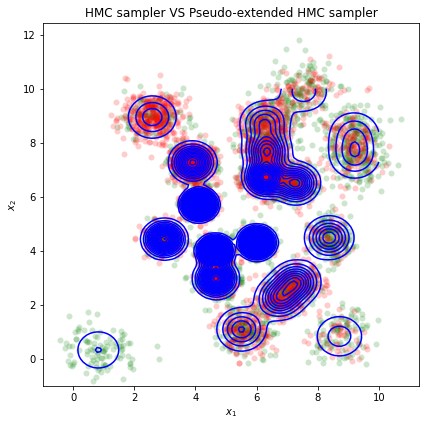

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
xx = np.linspace(-1, 10, 100)
xx, yy = np.meshgrid(xx, xx) # Create the 2D grid for plotting
Xtest = np.vstack([xx.flatten(), yy.flatten()]).T
ll2 = [log_f2(xi) for xi in Xtest] # Discretization samples of the actual target distribution for comparison with the output of the algorithm

# Plot the actual target distribution
axes.contour(xx, yy, np.exp(ll2).reshape(*xx.shape), 80, colors='b')
# Plot the samples obtained with the pseudo extended MCMC
axes.scatter(pseudoHMC2[:, 0], pseudoHMC2[:, 1], color='g', alpha=0.2, lw=0)
axes.scatter(sampsHMC[:, 0], sampsHMC[:, 1], color='r', alpha=0.2, lw=0)
axes.set_title(r"HMC sampler VS Pseudo-extended HMC sampler")
axes.set_xlabel(r"$x_1$")
axes.set_ylabel(r"$x_2$")
fig.tight_layout(pad=1)
plt.show()


La distribution cible est une mixture de vingt gaussiennes, et est représentée en bleu. Les points gris sont les estimations avec l'algorithme pseudo-extended. Les points rouges représentent l'algorithme HMC standard et les points verts représentent l'algorithme pseudo-extended présenté dans l'article.

On remarque que l'algorithme pseudo-extended capture les différents modes de la distribution, ce qui n'est pas le cas de l'algorithme HMC standard !